<div class="title">Practical Assignment: Supervised Learning</div>
<div class="subtitle">Machine Learning</div>
<div class="author">Carlos María Alaíz Gudín - Universidad Autónoma de Madrid</div>

---

**Configuración inicial del Notebook**

In [ ]:
%%html
<head><link rel="stylesheet" href="style.css"></head>

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

## **Enunciado de la práctica**

### **Introducción**

This practical assignment is designed as a **Kaggle competition**.

Specifically, a **multiclass classification** dataset will be used, so that each team will compete to improve their predictions over an unlabeled partition of the dataset.

It is important to remark that **the grades will not depend on the obtained ranking**, but on the different approaches used to tackle the problem, on the design of the experiments and on the analysis of the results.

### **Rúbrica**

The following aspects will be taken into account when evaluating the assignment.


* Analyse the data.


* Preprocess the features automatically using *pipelines*.


* Adjust the hyper-parameters with a validation stage.


* Try different models to improve the performance, at least:
    * (Regularized) Logistic Regression.
    * SVC.
    * ANNs.


* Try interpretable models to check the important features (e.g. Lasso).


* Submit the prediction at least once per week (the evolution of the performance will be also considered).


* Any other approach that may improve either the performance or interpretability of the model (e.g. feature selection, ensembles...).


* Analyse the results obtained after each experiment, and make decisions following the conclusions.

## **1. Importación de los paquetes y funciones auxiliares necesarios**

In [ ]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import warnings

from sklearn.metrics import accuracy_score, balanced_accuracy_score

########################################
# Any other needed package can be imported here:
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, lars_path, ElasticNet, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV,RepeatedStratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel
from pandas import Series
########################################

from Utils import plot_dataset_clas, evaluate_linear_model, evaluate_nonlinear_model, fun_cross_entropy, grad_cross_entropy

matplotlib.rc('figure', figsize=(15, 5))
seed = 123

### **Team Number**

A continuación se indica el **número del equipo**:

In [ ]:
########################################
# The team number should be inserted here:
team_number = 2
########################################

### **Evaluación del modelo**

La siguiente **función** evalúa un modelo multiclase (ya ajustado), calculando y mostrando el *accuracy* y el *balanced accuracy* para las particiones *training* y *test*.

In [ ]:
def evaluate_model(model, X_tr, y_tr, X_te, y_te, print_table=True):
    y_tr_p = model.predict(X_tr)
    y_te_p = model.predict(X_te)

    er_tr = [accuracy_score(y_tr, y_tr_p), balanced_accuracy_score(y_tr, y_tr_p)]
    er_te = [accuracy_score(y_te, y_te_p), balanced_accuracy_score(y_te, y_te_p)]

    ers = [er_tr, er_te]
    headers=["Acc", "Bal. Acc"]

    if print_table:
        print("%10s" % "", end="")
        for h in headers:
            print("%10s" % h, end="")
        print("")

        headersc = ["Train", "Test"]

        cnt = 0
        for er in ers:
            hc = headersc[cnt]
            cnt = cnt + 1
            print("%10s" % hc, end="")

            for e in er:
                print("%10.2f" % e, end="")
            print("")

    return ers

### **Guardado de las predicciones**

La siguiente **función** guarda las predicciones de la ***challenge partition*** en un archivo con sintaxis `Team_TT_YYYYMMDD-HHMMSS.pred`, donde `TT` se refiere al número del equipo, y `YYYYMMDD-HHMMSS` es la fecha, que permitirá distinguir las distintas entregas del equipo.

In [ ]:
import time

def save_predictions(y_ch_p, n_preds=500):
    if (len(y_ch_p) != n_preds):
        print("Error saving the predictions, it should be a vector of %d lables" % n_preds)
    else:
        time_str = time.strftime("%Y%m%d-%H%M%S")
        np.savetxt("Team_%02d_%s.txt" % (team_number, time_str), y_ch_p, fmt="%d")

## **2. Carga del *dataset***

En esta práctica, usaremos un *dataset* real tomado de Internet.
Concretamente, éste será el dataset [fetal health](https://www.kaggle.com/andrewmvd/fetal-health-classification) de Kaggle, que trata de clasificar la salud fetal en tres clases:
1. *Normal*.
2. *Suspect*.
3. *Pathological*.

Los datos *input* son un conjunto de $21$ variables extraídas a partir de cardiotocografías (CTGs).

La siguiente celda importa los datos, en particular mediante tres particiones:
1. Una *training partition*, correspondiente a `X_tr` y `y_tr`, para entrenar (y validar) los modelos.
2. Una *test partition*, correspondiente a `X_te` and `y_te`, para estimar el *performance* de los modelos.
3. Una *challenge partition*, correspondiente a `X_ch`. Los *labels* reales son desconocidos, de forma que las predicciones deben ser cargadas para conocer el *performance* real de los modelos.

In [ ]:
rootf = "fetal_health"

X_tr = np.loadtxt(rootf + "_tr.dat")
X_te = np.loadtxt(rootf + "_te.dat")
X_ch = np.loadtxt(rootf + "_ch.dat")

y_tr = np.loadtxt(rootf + "_tr.lab")
y_te = np.loadtxt(rootf + "_te.lab")

features = [line.rstrip('\n') for line in open("./fetal_health.head")]
n_features = len(features)
print(features)

['light decelerations', 'abnormal short term variability', 'severe decelerations', 'histogram median', 'uterine contractions', 'histogram mode', 'mean value of short term variability', 'histogram tendency', 'histogram number of zeroes', 'histogram number of peaks', 'histogram min', 'baseline value', 'accelerations', 'histogram mean', 'percentage of time with abnormal long term variability', 'histogram width', 'mean value of long term variability', 'prolongued decelerations', 'histogram variance', 'fetal movement', 'histogram max']


## **3. Análisis de los datos**

**Representación de los datos para las dos primeras características**

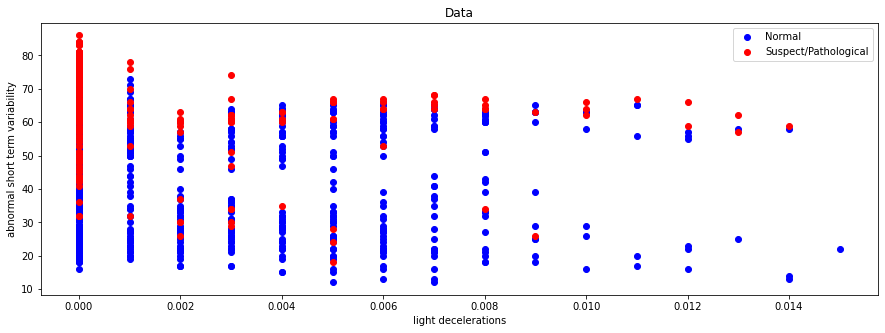

In [ ]:
plot_dataset_clas(X_tr, y_tr)
plt.xlabel(features[0])
plt.ylabel(features[1])
plt.legend(["Normal", "Suspect/Pathological"])
plt.axis("auto")
plt.show()

En esta gráfica, hemos dibujado nuestros datos, en base a la clase a la que pertenecen, para las dos primeras características de las 21 existentes. Esto lo podríamos representar para todas las demás posibles combinaciones de *features*. Como podemos apreciar, al menos en este caso, la gran mayoría de las muestras, sean de la clase que sean, se encuentran dentro de valores muy bajos de la característica "light decelerations", mientras que se distribuyen a lo largo de diversos valores de la característica "abnormal short term variability".

**Balance de las muestras entre los *datasets***

In [ ]:
for lab in np.unique(y_tr):
    n_sam = np.sum(y_tr == lab)
    print("Class %d: %3d samples (%5.2f%%)" % (lab, n_sam, 100.0 * n_sam / len(y_tr)))

Class 1: 877 samples (77.89%)
Class 2: 156 samples (13.85%)
Class 3:  93 samples ( 8.26%)


Como podemos apreciar, la mayoría de las muestras, de las 1126 existentes, son de tipo "normal", ya que pertenecen a la primera clase, mientras que 156 muestras pertenecen a la clase "suspect" y solo 93 son de tipo "pathological".

**Rango de las características para cada una de las clases**

Para cada una de las figuras que aparecen en la siguiente celda, en el eje de ordenadas se indica el nombre de la característica correspondiente, mientras que en el eje de abscisas se identifican los valores 1, 2 y 3 que se corresponden con las clases (normal, sospechoso y patológico, respectivamente).

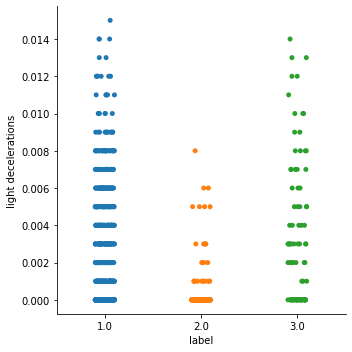

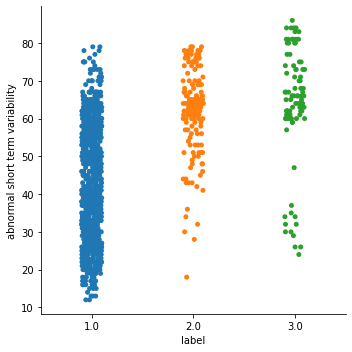

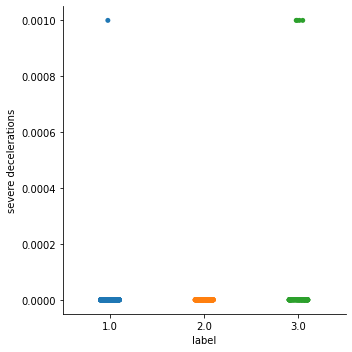

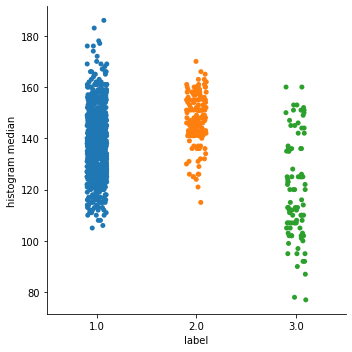

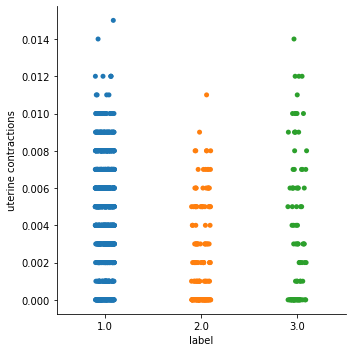

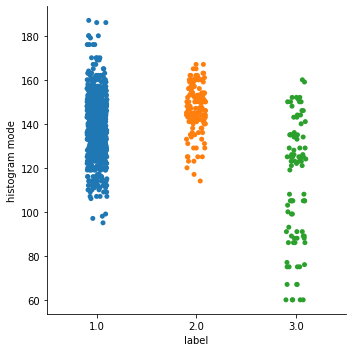

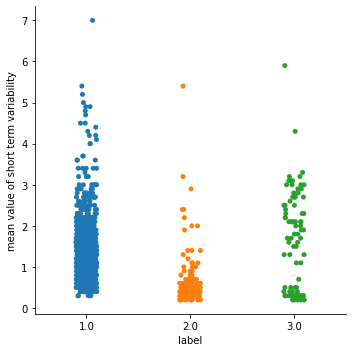

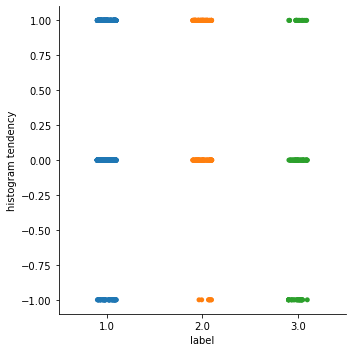

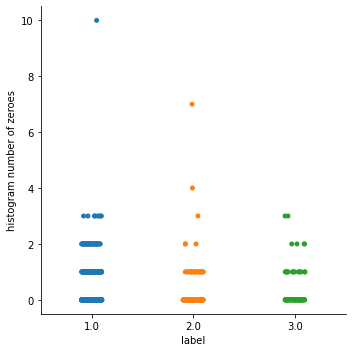

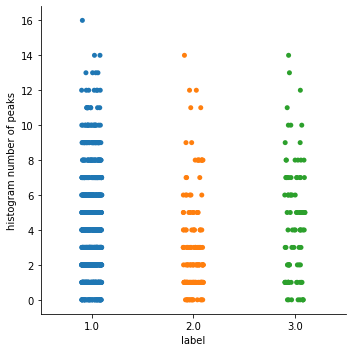

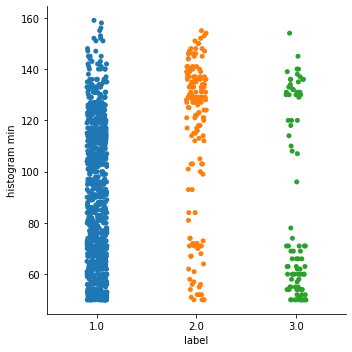

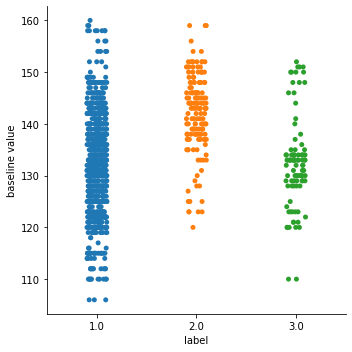

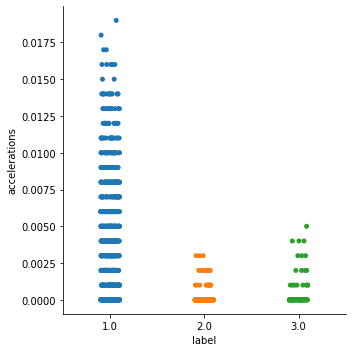

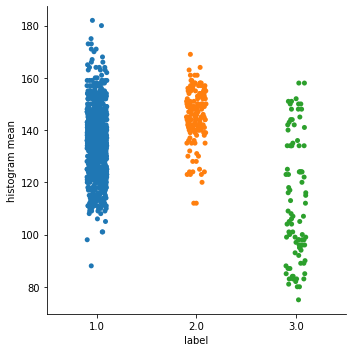

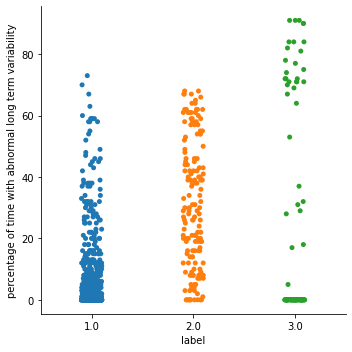

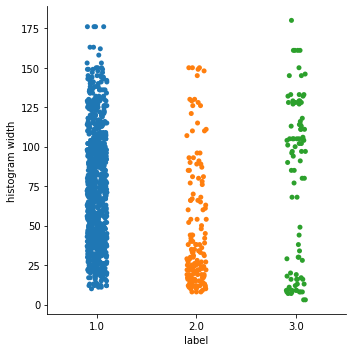

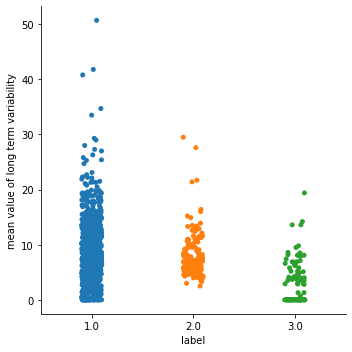

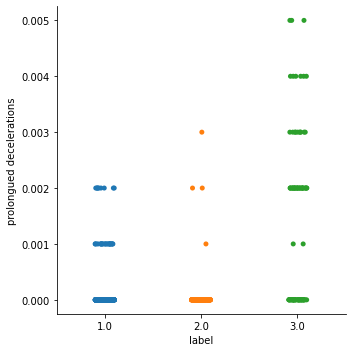

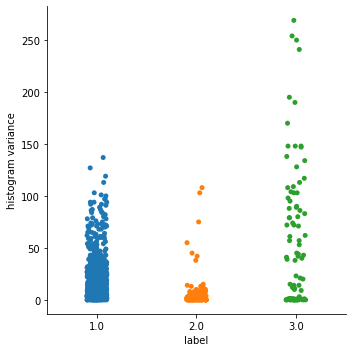

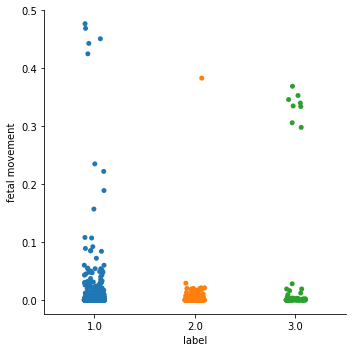

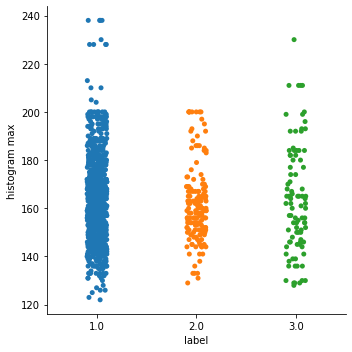

In [ ]:
import seaborn as sns
import pandas as pd
df_x = pd.DataFrame(X_tr)
df_y = pd.DataFrame(y_tr)
df_y_label=df_y.rename(columns = {0 : 'label'})
df_x_label = df_x.rename(columns = {0 : 'light decelerations', 
                                    1 : 'abnormal short term variability',
                                    2 : 'severe decelerations',
                                    3 : 'histogram median',
                                    4 : 'uterine contractions',
                                    5 : 'histogram mode',
                                    6 : 'mean value of short term variability',
                                    7 : 'histogram tendency',
                                    8 : 'histogram number of zeroes',
                                    9 : 'histogram number of peaks',
                                    10 : 'histogram min',
                                    11 : 'baseline value',
                                    12 : 'accelerations',
                                    13 : 'histogram mean',
                                    14 : 'percentage of time with abnormal long term variability',
                                    15 : 'histogram width',
                                    16 : 'mean value of long term variability',
                                    17 : 'prolongued decelerations',
                                    18 : 'histogram variance',
                                    19 : 'fetal movement',
                                    20 : 'histogram max'
                                    })
df_junto=pd.concat([df_x_label, df_y_label], axis=1)

for i in features:
  sns.catplot(x='label', y=i, data=df_junto)

En estas gráficas, por tanto, podemos apreciar cómo se distribuyen las muestras, separadas por clase, para los distintos posibles valores de cada una de las 21 características de nuestro *dataset*. Resultan llamativas las distintas formas en las que se distribuyen las muestras en función de la característica.

**Características que están relacionadas con las clases**

En la celda inferior, se obtiene un listado con los identificadores numéricos de las características significativamente relacionadas con cada una de las clases, según el estadístico F. 

In [ ]:
import sklearn
f_estadistico, p_valor = sklearn.feature_selection.f_classif(X_tr, y_tr)

for i in p_valor:
  if i < 0.001:
    print(np.where(p_valor==i))
    #Imprime el identificador numérico de la característica.

(array([0]),)
(array([1]),)
(array([2]),)
(array([3]),)
(array([4]),)
(array([5]),)
(array([6]),)
(array([7]),)
(array([9]),)
(array([10]),)
(array([11]),)
(array([12]),)
(array([13]),)
(array([14]),)
(array([15]),)
(array([16]),)
(array([17]),)
(array([18]),)
(array([19]),)


Además, tras ejecutar el código de la celda inferior, se obtiene una **matriz de correlación** entre cada una de las características. La intensidad de los colores de las celdas indica la fuerza de la correlación: cuanto más intenso, mayor correlación. Asimismo, las celdas en rojo y azul indican respectivamente una correlación directa e inversamente proporcional entre las características. Finalmente, el valor de cada celda indica cómo se relacionan entre sí cada par de características.

In [ ]:
import pandas
correlation = pandas.DataFrame(X_tr).corr()
correlation.style.background_gradient(cmap='coolwarm')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,1.000000,-0.147090,0.107444,-0.366871,0.318775,-0.333863,0.563379,-0.006562,0.235794,0.404473,-0.560953,-0.148452,-0.118707,-0.513151,-0.261964,0.532055,-0.216955,0.190110,0.589111,0.038993,0.230254
1,-0.147090,1.000000,0.019889,0.116549,-0.232775,0.049987,-0.431642,-0.012313,-0.150124,-0.188229,0.286551,0.302660,-0.245301,0.081903,0.442732,-0.263978,-0.316141,0.053723,-0.135780,-0.094073,-0.100690
2,0.107444,0.019889,1.000000,-0.153564,0.020310,-0.228948,0.037601,-0.058635,0.028229,0.008194,-0.081729,-0.054481,-0.048104,-0.158114,-0.036096,0.050751,-0.021211,0.026093,0.163032,-0.012706,-0.024466
3,-0.366871,0.116549,-0.153564,1.000000,-0.133066,0.932548,-0.343657,0.394277,-0.030044,-0.135789,0.430446,0.786357,0.270512,0.950696,0.189388,-0.199447,0.040067,-0.462580,-0.317610,-0.104210,0.275904
4,0.318775,-0.232775,0.020310,-0.133066,1.000000,-0.094558,0.318021,-0.067988,0.042415,0.120341,-0.147595,-0.136208,0.071745,-0.194329,-0.289279,0.185576,-0.068984,0.055881,0.277122,-0.060654,0.159379
5,-0.333863,0.049987,-0.228948,0.932548,-0.094558,1.000000,-0.305219,0.427455,-0.046608,-0.120736,0.385114,0.696457,0.243131,0.897086,0.168345,-0.196446,0.060589,-0.463621,-0.364698,-0.107118,0.207828
6,0.563379,-0.431642,0.037601,-0.343657,0.318021,-0.305219,1.000000,-0.089618,0.252470,0.508923,-0.626027,-0.277642,0.170649,-0.458679,-0.469794,0.664305,0.104803,0.251608,0.530371,0.095930,0.409823
7,-0.006562,-0.012313,-0.058635,0.394277,-0.067988,0.427455,-0.089618,1.000000,0.081562,0.090794,-0.205180,0.285130,0.017300,0.339759,0.061221,0.079502,0.147568,-0.257480,-0.108334,-0.012826,-0.165256
8,0.235794,-0.150124,0.028229,-0.030044,0.042415,-0.046608,0.252470,0.081562,1.000000,0.289992,-0.278632,0.019573,-0.013623,-0.070537,-0.111008,0.297795,0.084725,0.037626,0.175145,-0.008969,0.187011
9,0.404473,-0.188229,0.008194,-0.135789,0.120341,-0.120736,0.508923,0.090794,0.289992,1.000000,-0.669550,-0.132658,0.202373,-0.234751,-0.311339,0.744797,0.039086,0.198793,0.438485,0.152365,0.512670


Al observar la matriz, diferenciamos una diagonal de 1 en color rojo, puesto que cada característica está relacionada consigo misma positivamente. Como ejemplo de lectura, si nos fijamos en la coordenada (13,3), observamos que la correlación entre las variables es elevada (color intenso) y proporcional (color rojo). Como ejemplo contrario, la celda en la coordenada (8,0) presenta un color gris, tan cerca del azul como del rojo, lo que nos indica que la correlación entre esas características, si la hay, es débil.

Asimismo, la relación entre las características puede representarse por pares mediante **diagramas de dispersión**. Al tratarse de 21 características, contamos con 210 combinaciones posibles, motivo por el cual se ha optado por la matriz anterior de correlación. Sin embargo, como ejemplo para interpretar este tipo de diagramas, vamos a representar los dos ejemplos anteriores:

In [ ]:
sanos_posiciones=[]
sospechoso_posiciones=[]
enfermo_posiciones=[]
y_tr_list=y_tr.tolist()
for i in range(21):
  if df_junto['label'][i] == 1.0:
    sanos_posiciones.append(i)
  elif df_junto['label'][i] == 2.0:
    sospechoso_posiciones.append(i)
  else:
    enfermo_posiciones.append(i)

In [ ]:
X_tr_13 = X_tr[:,13]
X_tr_13.tolist()
X_tr_13_sanos=[]
X_tr_13_sospechoso=[]
X_tr_13_enfermo=[]
for i in sanos_posiciones:
  X_tr_13_sanos.append(X_tr_13[i])
for i in sospechoso_posiciones:
  X_tr_13_sospechoso.append(X_tr_13[i])
for i in enfermo_posiciones:
  X_tr_13_enfermo.append(X_tr_13[i])

In [ ]:
X_tr_3 = X_tr[:,3]
X_tr_3.tolist()
X_tr_3_sanos=[]
X_tr_3_sospechoso=[]
X_tr_3_enfermo=[]
for i in sanos_posiciones:
  X_tr_3_sanos.append(X_tr_3[i])
for i in sospechoso_posiciones:
  X_tr_3_sospechoso.append(X_tr_3[i])
for i in enfermo_posiciones:
  X_tr_3_enfermo.append(X_tr_3[i])

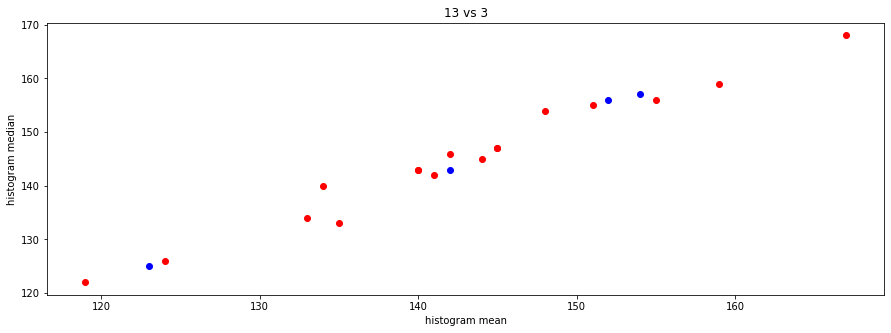

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X_tr_13_sanos, X_tr_3_sanos,c='red')
ax.scatter(X_tr_13_sospechoso, X_tr_3_sospechoso, c='blue')
ax.scatter(X_tr_13_enfermo, X_tr_3_enfermo,c='green') #parece que no está relacionado con los enfermos?
plt.xlabel(features[13])
plt.ylabel(features[3])
plt.title("13 vs 3")
plt.show()

En la matriz de correlación se nos indicaba que las características 13 y 3 estaban correlacionadas, y en el diagrama de dispersión se demuestra que a medida que aumenta una, la otra crece, dándose por tanto una consonancia entre lo reflejado por la matriz y el diagrama.

In [ ]:
X_tr_8 = X_tr[:,8]
X_tr_8.tolist()
X_tr_8_sanos=[]
X_tr_8_sospechoso=[]
X_tr_8_enfermo=[]
for i in sanos_posiciones:
  X_tr_8_sanos.append(X_tr_8[i])
for i in sospechoso_posiciones:
  X_tr_8_sospechoso.append(X_tr_8[i])
for i in enfermo_posiciones:
  X_tr_8_enfermo.append(X_tr_8[i])

In [ ]:
X_tr_0 = X_tr[:,0]
X_tr_0.tolist()
X_tr_0_sanos=[]
X_tr_0_sospechoso=[]
X_tr_0_enfermo=[]
for i in sanos_posiciones:
  X_tr_0_sanos.append(X_tr_0[i])
for i in sospechoso_posiciones:
  X_tr_0_sospechoso.append(X_tr_0[i])
for i in enfermo_posiciones:
  X_tr_0_enfermo.append(X_tr_0[i])

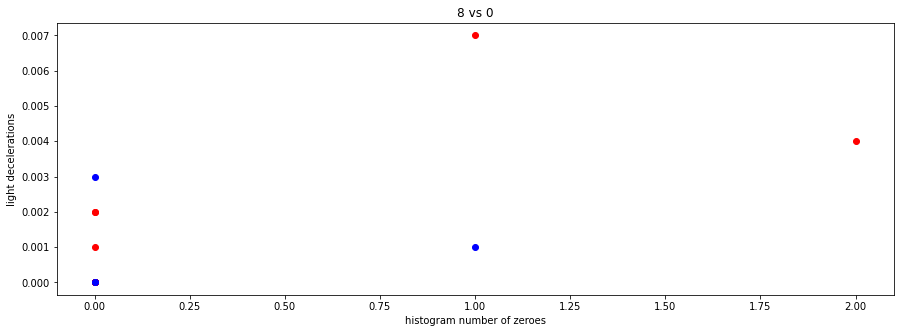

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X_tr_8_sanos, X_tr_0_sanos,c='red')
ax.scatter(X_tr_8_sospechoso, X_tr_0_sospechoso, c='blue')
ax.scatter(X_tr_8_enfermo, X_tr_0_enfermo,c='green')
plt.xlabel(features[8])
plt.ylabel(features[0])
plt.title("8 vs 0")
plt.show()

En la tabla de correlaciones se indicaba que las características 8 y 0 apenas estaban correlacionadas, ya que el color de la celda era gris. En el diagrama de dispersión anterior, se puede comprobar que no hay un patrón distinguible entre los puntos.

## **4. Pre-procesado de las características (*features*)**

A continuación, una vez hemos analizado los datos, vamos a pre-procesar los mismos, ya que este procedimiento, en el que los *features* se encuentran en una escala similar, mejora considerablemente el *performance* de los modelos de aprendizaje automático. Para ello, vamos a utilizar la herramienta de *sklearn* ***StandardScaler***, que estandariza las características eliminando la media y escalando a la varianza unitaria (del inglés, *unit variance*). Esto significa que todos los valores se dividen por la desviación estándar. La aplicación de *StandardScaler* resulta en una distribución cuya desviación estándar es igual a 1. La varianza, por su parte, también es 1, pues $varianza=(desv.estandar)^2$. *StandardScaler* hace que la media de la distribución sea aproximadamente 0. 

Dicho esto acerca de este método de estandarización de los *features*, vamos a llevarlo a cabo, con el fin de probar posteriormente varios métodos de aprendizaje automático sobre nuestro *dataset* y evaluar su *performance*, así como determinar los *features* más importantes usando modelos interpretables.

In [ ]:
scaler=StandardScaler()
X_std=scaler.fit_transform(X_tr) #Ajuste de los datos y posterior transformación de los mismos.

Esta variable *X_std* que acabamos de generar será de utilidad en el apartado 6 de este informe, en donde se utilizarán modelos interpretables para la extracción de las características más importantes. Por su parte, en el apartado 5, donde probaremos distintos modelos de aprendizaje automático y evaluaremos su *performance* sobre el *challenge partition*, llevaremos a cabo esta estandarización de los datos en las propias *Pipelines* que serán mostradas posteriormente.

## **5. Experimentos**

A continuación, utilizando varios modelos de aprendizaje automático, vamos a evaluar el *performance* de los mismos sobre nuestro *dataset*, y determinar cuál o cuáles de ellos presentan un mayor *balanced accuracy score*. 

Para ello, vamos a generar para cada experimento una ***Pipeline***, en donde directamente pre-procesemos los datos (con *StandardScaler*) y apliquemos un modelo de aprendizaje automático con los mejores valores de sus parámetros posibles, dentro de los especificados en el experimento, sobre nuestras particiones *training* y *test*. Además, evaluaremos cada modelo sobre la *challenge partition*, dando lugar a un fichero .txt con la predicción de la clase a la que pertenece cada muestra según dicho modelo, con mayor o menor precisión en base a cómo de eficiente sea éste.

Esta selección de los hiperparámetros óptimos se realizará junto con un proceso de **validación cruzada**, tal y como indica el enunciado de la actividad, con el fin de reducir la varianza de los resultados. Esto será llevado a cabo concretamente con la función de *sklearn* llamada *RepeatedStratifiedKFold*, con 5 splits y 10 repeticiones. Esta validación cruzada será posteriormente utilizada para la función *GridSearchCV* de *sklearn*, que tratará de encontrar los valores de los parámetros idóneos dentro de los indicados en la celda de código correspondiente en relación a un estimador (en nuestro caso, el modelo de aprendizaje automático).

### **5.1: EXPERIMENTO 1: *DummyClassifier***

In [ ]:
warnings.filterwarnings("ignore", category=Warning) #ignoramos los warnings
pipeline_dummy = Pipeline([("scaler",StandardScaler()),("dummy",DummyClassifier())]) #construimos la pipeline.
param_grid_dummy = {"dummy__strategy":["prior","stratified","most_frequent","uniform","constant"]} #indicamos los parámetros a optimizar y sus posibles valores.
skfold_dummy=RepeatedStratifiedKFold(n_splits=5,n_repeats=5) #validación cruzada estratificada de 5 iteraciones, en este caso.
gridcv_dummy=GridSearchCV(pipeline_dummy,param_grid_dummy,cv=skfold_dummy,scoring=make_scorer(balanced_accuracy_score)) #búsqueda de los parámetros óptimos.
gridcv_dummy.fit(X_tr, y_tr) #ajuste sobre la *training partition*.
y_ch_p_dummy=gridcv_dummy.predict(X_ch) #evaluación sobre la *challenge partition*.
evaluate_model(gridcv_dummy, X_tr, y_tr, X_te, y_te) #obtención de las medidas del *performance* del modelo sobre las particiones *training* y *test*.
print("Los mejores parámetros son:",gridcv_dummy.best_params_) #mejores parámetros.
print("El mejor balanced accuracy score es:",gridcv_dummy.best_score_) #mejor balanced accuracy score.

                 Acc  Bal. Acc
     Train      0.33      0.34
      Test      0.34      0.33
Los mejores parámetros son: {'dummy__strategy': 'uniform'}
El mejor balanced accuracy score es: 0.339401152808708


In [ ]:
save_predictions(y_ch_p_dummy)

En este caso, podemos apreciar que el *performance* de este clasificador no es buena, lo cual tiene sentido, pues este clasificador hace predicciones ignorando las *input features*.

### **5.2: EXPERIMENTO 2: Regresión Logística (regularización L1)**

In [ ]:
#warnings.filterwarnings("ignore", category=Warning)
pipeline_lg_1 = Pipeline([("scaler",StandardScaler()),("LG",LogisticRegression(fit_intercept=True,penalty="l1"))])
param_grid_lg_1 = {"LG__solver":["liblinear","saga"],"LG__C":[100,200,1000,2000],"LG__max_iter":[150,200,250,300]}
skfold_lg_1=RepeatedStratifiedKFold(n_splits=5,n_repeats=10)
gridcv_lg_1=GridSearchCV(pipeline_lg_1,param_grid_lg_1,cv=skfold_lg_1,scoring=make_scorer(balanced_accuracy_score))
result_lg_1=gridcv_lg_1.fit(X_tr, y_tr)
y_ch_p_lg_1=gridcv_lg_1.predict(X_ch)
evaluate_model(gridcv_lg_1, X_tr, y_tr, X_te, y_te)
print("Los mejores parámetros son:",gridcv_lg_1.best_params_)
print("El mejor balanced accuracy score es:",gridcv_lg_1.best_score_)

                 Acc  Bal. Acc
     Train      0.91      0.82
      Test      0.89      0.78
Los mejores parámetros son: {'LG__C': 200, 'LG__max_iter': 250, 'LG__solver': 'saga'}
El mejor balanced accuracy score es: 0.7880615919074323


In [ ]:
save_predictions(y_ch_p_lg_1)

En este caso, podemos apreciar que, para unos valores intermedios de los parámetros *C* y *max_iter*, se obtienen los mejores resultados, considerando que *C* es el inverso de la fuerza de regularización (por lo que su valor influye en el *overfitting*  y/o el *underfitting* del modelo) y *max_iter* es el número de iteraciones del solver (algoritmo empleado para la optimización). Aparte, como podemos comprobar, el algoritmo *solver* depende básicamente del tipo de regularización que estemos aplicando, en este caso L1.

### **5.3: EXPERIMENTO 3: Regresión Logística (regularización L2)**

In [ ]:
warnings.filterwarnings("ignore", category=Warning)
pipeline_lg_2 = Pipeline([("scaler",StandardScaler()),("LG",LogisticRegression(fit_intercept=True,penalty="l2"))])
param_grid_lg_2 = {"LG__solver":["lbfgs","sag","newton-cg","saga","liblinear"],"LG__C":[100,200,1000,2000],"LG__max_iter":[150,200,250,300]}
skfold_lg_2=RepeatedStratifiedKFold(n_splits=5,n_repeats=10)
gridcv_lg_2=GridSearchCV(pipeline_lg_2,param_grid_lg_2,cv=skfold_lg_2,scoring=make_scorer(balanced_accuracy_score))
result_lg_2=gridcv_lg_2.fit(X_tr, y_tr)
y_ch_p_lg_2=gridcv_lg_2.predict(X_ch)
evaluate_model(gridcv_lg_2, X_tr, y_tr, X_te, y_te)
print("Los mejores parámetros son:",gridcv_lg_2.best_params_)
print("El mejor balanced accuracy score es:",gridcv_lg_2.best_score_)

                 Acc  Bal. Acc
     Train      0.92      0.82
      Test      0.90      0.79
Los mejores parámetros son: {'LG__C': 1000, 'LG__max_iter': 150, 'LG__solver': 'saga'}
El mejor balanced accuracy score es: 0.7876852228118358


In [ ]:
save_predictions(y_ch_p_lg_2)

En este caso, podemos apreciar que, para unos valores intermedios de los parámetros *C* y *max_iter*, se obtienen los mejores resultados, considerando que *C* es el inverso de la fuerza de regularización (por lo que su valor influye en el *overfitting*  y/o el *underfitting* del modelo) y *max_iter* es el número de iteraciones del *solver* (algoritmo empleado para la optimización). Aparte, como podemos comprobar, el algoritmo *solver* depende básicamente del tipo de regularización que estemos aplicando, en este caso L2.

### **5.4: EXPERIMENTO 4: Regresión Logística (con *Elastic Net*)**

In [ ]:
warnings.filterwarnings("ignore", category=Warning)
pipeline_lg_elasticnet = Pipeline([("scaler",StandardScaler()),("LG",LogisticRegression(fit_intercept=True, penalty="elasticnet", solver="saga"))])
param_grid_lg_elasticnet = {"LG__l1_ratio":[0.1,0.5,0.9],"LG__C":[100,200,1000,2000],"LG__max_iter":[150,200,250,300]}
skfold_lg_elasticnet=RepeatedStratifiedKFold(n_splits=5,n_repeats=10)
gridcv_lg_elasticnet=GridSearchCV(pipeline_lg_elasticnet,param_grid_lg_elasticnet,cv=skfold_lg_elasticnet,scoring=make_scorer(balanced_accuracy_score))
result_lg_elasticnet=gridcv_lg_elasticnet.fit(X_tr, y_tr)
y_ch_p_lg_elasticnet=gridcv_lg_elasticnet.predict(X_ch)
evaluate_model(gridcv_lg_elasticnet, X_tr, y_tr, X_te, y_te)
print("Los mejores parámetros son:",gridcv_lg_elasticnet.best_params_)
print("El mejor balanced accuracy score es:",gridcv_lg_elasticnet.best_score_)

                 Acc  Bal. Acc
     Train      0.91      0.82
      Test      0.89      0.78
Los mejores parámetros son: {'LG__C': 100, 'LG__l1_ratio': 0.1, 'LG__max_iter': 250}
El mejor balanced accuracy score es: 0.7865522854668441


In [ ]:
save_predictions(y_ch_p_lg_elasticnet)

En este caso, podemos apreciar que, para unos valores intermedios de los parámetros *C* y *max_iter*, así como bajos de *l1_ratio* se obtienen los mejores resultados, considerando que *C* es el inverso de la fuerza de regularización (por lo que su valor influye en el *overfitting*  y/o el *underfitting* del modelo) y *max_iter* es el número de iteraciones del solver (algoritmo empleado para la optimización), mientras que *l1_ratio* es un parámetro exclusivo de *ElasticNet*, ya que este regularizador se basa en la combinación de los regularizadores L1 y L2. Nótese que el *solver* utilizado es *saga*, ya que solamente este permite emplear *ElasticNet* como regularizador.

### **5.5: EXPERIMENTO 5: *Random Forest Classifier***

In [ ]:
pipeline_rf = Pipeline([("scaler",StandardScaler()),("RF",RandomForestClassifier())])
param_grid_rf = {"RF__n_estimators":[10,20,30],
             "RF__criterion":["gini","entropy","log_loss"],
             "RF__max_depth":[2,3,4],
             "RF__min_samples_split":[2,3],
             "RF__min_samples_leaf":[2,3],
             "RF__min_weight_fraction_leaf":[0.0,0.1],
             "RF__max_features":[5,len(features)],
             "RF__ccp_alpha":[0.0,0.1]}
skfold_rf=RepeatedStratifiedKFold(n_splits=5,n_repeats=10)
gridcv_rf=GridSearchCV(pipeline_rf,param_grid_rf,cv=skfold_rf,scoring=make_scorer(balanced_accuracy_score))
result_rf=gridcv_rf.fit(X_tr, y_tr)
y_ch_p_rf=gridcv_rf.predict(X_ch)
evaluate_model(gridcv_rf, X_tr, y_tr, X_te, y_te)
print("Los mejores parámetros son:",gridcv_rf.best_params_)
print("El mejor balanced accuracy score es:",gridcv_rf.best_score_)

                 Acc  Bal. Acc
     Train      0.94      0.86
      Test      0.91      0.82
Los mejores parámetros son: {'RF__ccp_alpha': 0.0, 'RF__criterion': 'entropy', 'RF__max_depth': 4, 'RF__max_features': 21, 'RF__min_samples_leaf': 3, 'RF__min_samples_split': 3, 'RF__min_weight_fraction_leaf': 0.0, 'RF__n_estimators': 10}
El mejor balanced accuracy score es: 0.8284092674052352


In [ ]:
save_predictions(y_ch_p_rf)

En este caso, podemos apreciar que, para unos valores intermedios de la mayoría de los parámetros calibrados en esta *Pipeline*, se obtienen los mejores resultados. En general, cabría esperar que a mayor número de estimadores (es decir, número de árboles del bosque) y mayor valor del parámetro *max_depth* (profundidad máxima del árbol; en general, a mayor valor más splits posee, capturando más información acerca de los datos, dentro de un valor razonable), mejor *performance*. Sin embargo, esto depende en cierta medida de los datos sobre los que esté entrenando el clasificador, y también puede que busquemos no ralentizar el proceso de aprendizaje, por lo que lo apropiado es hacer una búsqueda de parámetros apropiados, tal y como hemos hecho en esta práctica, resultando unos valores más bien intermedios, como se ha mencionado al inicio de este párrafo.

### **5.6: EXPERIMENTO 6: *Decision Tree Classifier***

In [ ]:
pipeline_dtc = Pipeline([("scaler",StandardScaler()),("DTC",DecisionTreeClassifier(random_state=1))])
param_grid_dtc = {"DTC__max_depth":np.arange(0,51,5).astype(np.int),
                "DTC__criterion":["gini","entropy","log_loss"],
                "DTC__min_samples_split":[2,3],
                "DTC__min_samples_leaf":[2,3],
                "DTC__min_weight_fraction_leaf":[0.0,0.5],
                "DTC__max_features":[5,len(features)],
                "DTC__ccp_alpha":[0.0,0.1]}
skfold_dtc=RepeatedStratifiedKFold(n_splits=5,n_repeats=10)
gridcv_dtc=GridSearchCV(pipeline_dtc,param_grid_dtc,cv=skfold_dtc,scoring=make_scorer(balanced_accuracy_score))
result_dtc=gridcv_dtc.fit(X_tr, y_tr)
y_ch_p_dtc=gridcv_dtc.predict(X_ch)
evaluate_model(gridcv_dtc, X_tr, y_tr, X_te, y_te)
print("Los mejores parámetros son:",gridcv_dtc.best_params_)
print("El mejor balanced accuracy score es:",gridcv_dtc.best_score_)

                 Acc  Bal. Acc
     Train      0.99      0.97
      Test      0.92      0.82
Los mejores parámetros son: {'DTC__ccp_alpha': 0.0, 'DTC__criterion': 'entropy', 'DTC__max_depth': 10, 'DTC__max_features': 21, 'DTC__min_samples_leaf': 2, 'DTC__min_samples_split': 2, 'DTC__min_weight_fraction_leaf': 0.0}
El mejor balanced accuracy score es: 0.833780514764428


In [ ]:
save_predictions(y_ch_p_dtc)

En este caso, podemos apreciar que, para unos valores intermedios de la mayoría de los parámetros calibrados en esta *Pipeline*, se obtienen los mejores resultados. En primer lugar, encontramos *criterion*, que mide la calidad del *split*, y por lo general los criterios "gini", "entropy" y "log_loss" no son muy decisivos en el *performance del modelo*, ya que uno es mejor para ciertos casos y el otro para otros casos (en el nuestro, parece ser mejor "entropy"). Respecto al parámetro *max_depth*, éste se refiere a la profundidad máxima del árbol. Por lo general, éste parámetro debe encontrarse dentro de un valor intermedio, para evitar tanto el *overfitting* como el *underfitting*, algo que se ha cumplido en este caso. Respecto al parámetro *min_samples_leaf*, éste se refiere al número mínimo de muestras requeridas para formar un nodo en el árbol, y sirve fundamentalmente para controlar el *overfitting*. Al igual que con el parámetro anterior, lo más apropiado es usar un valor intermedio dentro de los especificados en la *Pipeline*. En relación a los parámetros *min_samples_split* y *min_weight_fraction_leaf*, éstos se refieren al mínimo número de muestras requeridas para dividir (del inglés, *split*) un nodo interno del árbol y a la fracción ponderada mínima de la suma total de pesos requeridos para ser un nodo del árbol, respectivamente. Al igual que con los parámetros anteriores, lo más apropiado es usar un valor intermedio. Finalmente, el parámetro *ccp_alpha* se refiere a la complejidad usada para el llamado *Minimal Cost-Complexity Pruning*. Como vemos, en este caso parece no ser conveniente hacer *pruning*, es decir, la reducción del tamaño del árbol eliminando partes no relevantes, al igual que ocurría con el experimento anterior, referente al modelo *Random Forest*.

### **5.7: EXPERIMENTO 7: *AdaBoost***

In [ ]:
pipeline_abc = Pipeline([("scaler",StandardScaler()),("ABC",AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1)))])
param_grid_abc = {"ABC__n_estimators":np.arange(10,101,10),"ABC__learning_rate":np.arange(0.0,0.91,0.1)}
skfold_abc = RepeatedStratifiedKFold(n_splits=5,n_repeats=10)
gridcv_abc = GridSearchCV(pipeline_abc,param_grid_abc,cv=skfold_abc,scoring=make_scorer(balanced_accuracy_score))
result_abc = gridcv_abc.fit(X_tr, y_tr)
y_ch_p_abc = gridcv_abc.predict(X_ch)
evaluate_model(gridcv_abc, X_tr, y_tr, X_te, y_te)
print("Los mejores parámetros son:",gridcv_abc.best_params_)
print("El mejor balanced accuracy score es:",gridcv_abc.best_score_)

                 Acc  Bal. Acc
     Train      0.90      0.83
      Test      0.87      0.77
Los mejores parámetros son: {'ABC__learning_rate': 0.9, 'ABC__n_estimators': 100}
El mejor balanced accuracy score es: 0.7841904625526017


In [ ]:
save_predictions(y_ch_p_abc)

Para este clasificador, la precisión es también bastante buena, al igual que ocurría con los demás (salvo *Dummy Classifier*). Como vemos, este clasificador parece tener mejor *performance* con un valor alto del número de estimadores, lo cual se explica en base a lo indicado para el modelo *Random Forest* anteriormente. Como cabría esperar, además, a mayor *learning_rate*, mejor es también el *performance* del modelo. Este clasificador, recordemos, es un estimador que ajusta un clasificador base (en este caso, un árbol de decisión) sobre los datos y luego ajusta copias adicionales del clasificador sobre los mismos datos, en donde los pesos de los *instances* incorrectamente clasificados son ajustados de forma que los clasificadores subsiguientes se centran más en casos más complejos.

### **5.8: EXPERIMENTO 8: *Bagging Classifier***

In [ ]:
pipeline_bc = Pipeline([("scaler",StandardScaler()),("BC",BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=1)))])
param_grid_bc = {"BC__n_estimators":np.arange(100,201,50),"BC__max_samples":[1,2,3],"BC__max_features":[1,2,3]}
skfold_bc=RepeatedStratifiedKFold(n_splits=5,n_repeats=10)
gridcv_bc=GridSearchCV(pipeline_bc,param_grid_bc,cv=skfold_bc,scoring=make_scorer(balanced_accuracy_score))
result_bc=gridcv_bc.fit(X_tr, y_tr)
y_ch_p_bc=gridcv_bc.predict(X_ch)
evaluate_model(gridcv_bc, X_tr, y_tr, X_te, y_te)
print("Los mejores parámetros son:",gridcv_bc.best_params_)
print("El mejor balanced accuracy score es:",gridcv_bc.best_score_)

                 Acc  Bal. Acc
     Train      0.78      0.33
      Test      0.78      0.33
Los mejores parámetros son: {'BC__max_features': 1, 'BC__max_samples': 1, 'BC__n_estimators': 100}
El mejor balanced accuracy score es: 0.33333333333333326


In [ ]:
save_predictions(y_ch_p_bc)

En este caso, podemos apreciar que el *performance* de este clasificador, para los parámetros más apropiados dentro de los especificados en la *Pipeline*, no es precisamente bueno, asemejándose al del *Dummy Classifier*. Esto se analizará con detalle al final de la sección.

### **5.9: EXPERIMENTO 9: *K-Nearest Neighbors Classifier***

In [ ]:
pipeline_knn = Pipeline([("scaler",StandardScaler()),("KNN",KNeighborsClassifier())])
param_grid_knn = {"KNN__n_neighbors":np.arange(0,51,1).astype(np.int),"KNN__weights":["uniform","distance"],"KNN__algorithm":["ball_tree","kd_tree","brute"]}
skfold_knn=RepeatedStratifiedKFold(n_splits=5,n_repeats=10)
gridcv_knn=GridSearchCV(pipeline_knn,param_grid_knn,cv=skfold_knn,scoring=make_scorer(balanced_accuracy_score))
result_knn=gridcv_knn.fit(X_tr, y_tr)
y_ch_p_knn=gridcv_knn.predict(X_ch)
evaluate_model(gridcv_knn, X_tr, y_tr, X_te, y_te)
print("Los mejores parámetros son:",gridcv_knn.best_params_)
print("El mejor balanced accuracy score es:",gridcv_knn.best_score_)

                 Acc  Bal. Acc
     Train      1.00      1.00
      Test      0.90      0.77
Los mejores parámetros son: {'KNN__algorithm': 'ball_tree', 'KNN__n_neighbors': 3, 'KNN__weights': 'distance'}
El mejor balanced accuracy score es: 0.7778016938117532


In [ ]:
save_predictions(y_ch_p_knn)

En este caso, este clasificador también parece tener un buen grado de precisión para nuestros datos, al igual que la mayoría de los demás clasificadores evaluados en este informe. Concretamente, lo más apropiado es un número relativamente bajo de vecinos, aunque esto depende del *dataset* con el que se esté manejando, luego no hay unos valores más óptimos de forma general. Respecto al algoritmo (*algorithm*) o los pesos (*weights*), estos también varían en su idoneidad en base al tipo de datos usados en cuestión para el modelo. En este caso, *ball_tree* y *distance*, respectivamente, parecen ser los más adecuados para nuestros datos.

### **5.10: EXPERIMENTO 10: *Gradient Boosting Classifier***

In [ ]:
pipeline_gb = Pipeline([("scaler",StandardScaler()),("GBM",GradientBoostingClassifier(random_state=0))])
param_grid_gb = {"GBM__n_estimators":np.arange(10,51,10).astype(np.int),
             "GBM__max_depth":[3,4],
             "GBM__learning_rate":[0.1,0.3],
             "GBM__min_samples_split":[2,3],
             "GBM__min_samples_leaf":[2,3],
             "GBM__subsample":[0.5,0.7],
             "GBM__ccp_alpha":[0.0,0.01]}
skfold_gb=RepeatedStratifiedKFold(n_splits=5,n_repeats=10)
gridcv_gb=GridSearchCV(pipeline_gb,param_grid_gb,cv=skfold_gb,scoring=make_scorer(balanced_accuracy_score))
result_gb=gridcv_gb.fit(X_tr,y_tr)
y_ch_p_gb=gridcv_gb.predict(X_ch)
evaluate_model(gridcv_gb, X_tr, y_tr, X_te, y_te)
print("Los mejores valores para los parámetros son: ",gridcv_gb.best_params_)
print("El mejor balanced accuracy score es:",gridcv_gb.best_score_)

                 Acc  Bal. Acc
     Train      1.00      1.00
      Test      0.93      0.85
Los mejores valores para los parámetros son:  {'GBM__ccp_alpha': 0.0, 'GBM__learning_rate': 0.3, 'GBM__max_depth': 3, 'GBM__min_samples_leaf': 2, 'GBM__min_samples_split': 2, 'GBM__n_estimators': 50, 'GBM__subsample': 0.7}
El mejor balanced accuracy score es: 0.874834186190468


In [ ]:
save_predictions(y_ch_p_gb)

En este caso, este modelo de *Gradient Boosting* parece ser uno de los mejores modelos evaluados en este informe, con una precisión sobre el *test set* del 86% aproximadamente, la cual es muy favorable. Para este clasificador, que es también un *ensemble method* al igual que RF o DTC, encontramos también que un mayor número de estimadores resulta en mejoras en el *performance* del modelo, así como unos valores intermedios para el resto de parámetros (excepto *ccp_alpha*, que sigue siendo 0). Considerando la robustez de este clasificador, era esperable obtener tal grado de precisión.

### **5.11: EXPERIMENTO 11: *Support Vector Classifier***

In [ ]:
pipeline_svc = Pipeline([("scaler",StandardScaler()),("SVC",SVC())])
param_grid_svc = {"SVC__C":[1e2,1e3,1e4],
             "SVC__kernel":["linear","rbf","poly"]}
skfold_svc=RepeatedStratifiedKFold(n_splits=5,n_repeats=10)
gridcv_svc=GridSearchCV(pipeline_svc,param_grid_svc,cv=skfold_svc,scoring=make_scorer(balanced_accuracy_score))
result_svc=gridcv_svc.fit(X_tr,y_tr)
y_ch_p_svc=gridcv_svc.predict(X_ch)
evaluate_model(gridcv_svc, X_tr, y_tr, X_te, y_te)
print("Los mejores valores para los parámetros son: ",gridcv_svc.best_params_)
print("El mejor balanced accuracy score es:",gridcv_svc.best_score_)

                 Acc  Bal. Acc
     Train      0.99      0.98
      Test      0.92      0.84
Los mejores valores para los parámetros son:  {'SVC__C': 100.0, 'SVC__kernel': 'rbf'}
El mejor balanced accuracy score es: 0.8295531890576882


In [ ]:
save_predictions(y_ch_p_svc)

En este caso, usando un *Support Vector Classifier* sobre nuestros datos, obtenemos también un buen grado de precisión, dada su robustez y su capacidad para controlar la complejidad de los datos. En este caso, para un valor de *C* bajo (dentro de los especificados en la *Pipeline*), parece existir una mejor *performance* para el modelo. Recordemos que, al igual que con la regresión logística, este parámetro es el inverso a la fuerza de la regularización. Respecto al *kernel*, cada uno es más apropiado en función de los datos empleados para entrenar el modelo; en este caso, *rbf* parece ser el más adecuado.

### **5.12: EXPERIMENTO 12: *Artificial Neural Network***

In [ ]:
warnings.filterwarnings("ignore", category=Warning)
pipeline_ann = Pipeline([("scaler",StandardScaler()),("ANN",MLPClassifier())])
param_grid_ann = {"ANN__hidden_layer_sizes":[(150,100,50)],
                "ANN__activation":["tanh","relu"],
                "ANN__solver":["sgd","adam"],
                "ANN__learning_rate":["constant","adaptive"],
                "ANN__alpha":[0.0001,0.05],
                "ANN__max_iter":[50,100]}
skfold_ann=RepeatedStratifiedKFold(n_splits=5,n_repeats=10)
gridcv_ann=GridSearchCV(pipeline_ann,param_grid_ann,cv=skfold_ann,scoring=make_scorer(balanced_accuracy_score))
result_ann=gridcv_ann.fit(X_tr, y_tr)
y_ch_p_ann=gridcv_ann.predict(X_ch)
evaluate_model(gridcv_ann, X_tr, y_tr, X_te, y_te)
print("Los mejores parámetros son:",gridcv_ann.best_params_)
print("El mejor balanced accuracy score es:",gridcv_ann.best_score_)

                 Acc  Bal. Acc
     Train      0.98      0.96
      Test      0.92      0.84
Los mejores parámetros son: {'ANN__activation': 'tanh', 'ANN__alpha': 0.05, 'ANN__hidden_layer_sizes': (150, 100, 50), 'ANN__learning_rate': 'adaptive', 'ANN__max_iter': 100, 'ANN__solver': 'adam'}
El mejor balanced accuracy score es: 0.8342132330663741


In [ ]:
save_predictions(y_ch_p_ann)

Para esta red neuronal artificial, hemos obtenido también una de las mejores precisiones de las evidenciadas y descritas en este informe. Esto era también esperable dado el gran poder computacional de estas redes y su buena capacidad para ajustarse y representar los datos, en relación a posibles relaciones no lineales y complejas entre los mismos. En este caso, respecto a los parámetros especificados en la *Pipeline* expuesta anteriormente, podemos deducir que los valores escogidos son los más apropiados para los datos que estamos manejando en este caso. 

### **5.13. ¿Por qué cada modelo tiene una precisión distinta?**

En esta tabla podemos encontrar un resumen de las precisiones de cada modelo:

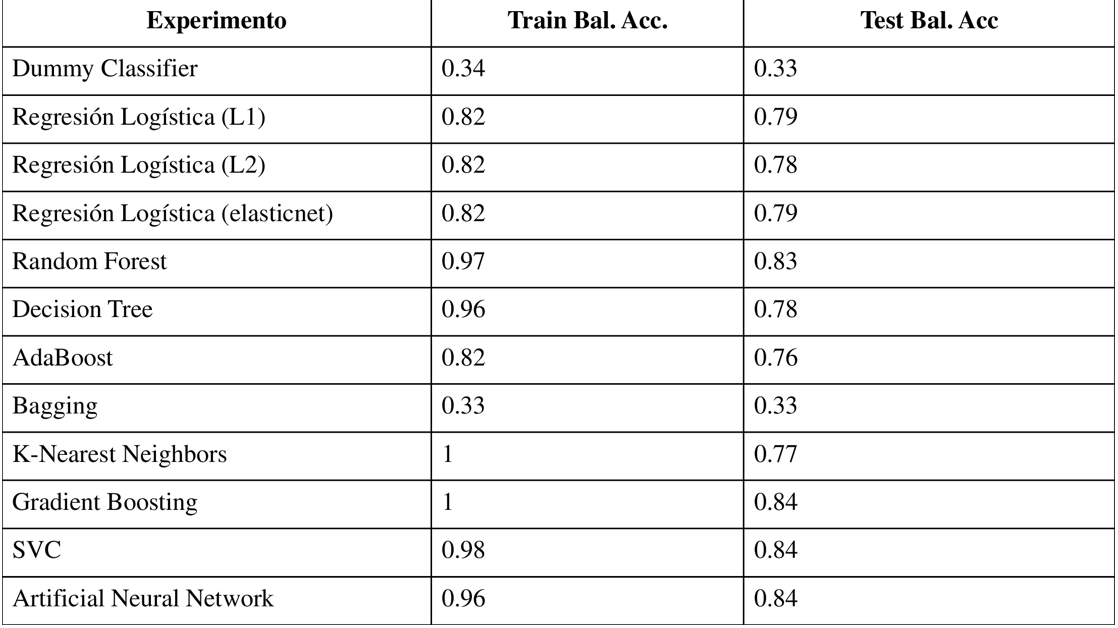

Al observarla vemos que, en general, las precisiones para cada modelo toman valores entre 0.76 y 0.84 para la partición de test, mientras que para la partición de entrenamiento toma valores entre 0.82 y 1, salvo ciertas excepciones.

Centrándonos en los datos particulares, cabe destacar que **el modelo de redes neuronales, así como el de *Gradient Boosting* y el de *Support Vector Classifier*, son los que han demostrado tener la mejor precisión para ambas particiones**, aunque los de *Random Forest* y *Decision Tree* han demostrado poseer también un buen grado de precisión. 

Asimismo, destacan las precisiones del *Dummy Classifier* y del *Bagging Classifier* por ser bastante bajas relativamente, en torno al 0.33 concretamente. Para el primer clasificador, como el propio nombre indica, esto era algo esperable. Sin embargo, nos llamó la atención este resultado para el *Bagging Classifier*, puesto que se basa en el ensamblado de modelos que al combinarse suelen generar una combinación robusta que reduce el *overfitting*. 

De esta forma, encontramos que las predicciones se basan en la media o moda votada por cada uno de los modelos que han corrido en paralelo, lo cual reduce el *overfitting* puesto que disminuye la variabilidad entre las predicciones (varianza), pero puede aumentar el *bias*, es decir, la diferencia entre las predicciones y el valor real, de tal forma que, si la reducción en la varianza no compensa el aumento del *bias*, se puede producir *underfitting* tal y como ha ocurrido en este caso.

## **6. Modelos interpretables para extraer los *features* más importantes**

A continuación, vamos a utilizar tres modelos de aprendizaje automático para extraer las características (del inglés, *features*) más importantes:

1. **Regresión Logística con regularización L1** (equivalente a ***Lasso***)
2. **Regresión Logística con regularización L2** (equivalente a ***Ridge***)
3. ***Random Forest*** (*tree-based feature selection*)

Además, estudiaremos brevemente cómo mejora cuantitativamente el *performance* de estos tres modelos la selección de características.

### **6.1: MODELO 1: *LogisticRegression* y regularización L1 (equivalente a Lasso)**

#### **6.1.1: Valor del parámetro C=0.01**

In [ ]:
print(X_tr.shape,X_te.shape) #Determinamos el tamaño del train set y el test set

(1126, 21) (500, 21)


In [ ]:
# Entrenamos un modelo de regresión logística con regularización L1
model_lr1 = LogisticRegression(C=0.01, penalty='l1', solver='liblinear') #usamos unos valores concretos de los parámetros
selection_lr1=SelectFromModel(model_lr1)
selection_lr1.fit(X_std, y_tr) #ajustamos sobre los datos ya pre-procesados

SelectFromModel(estimator=LogisticRegression(C=0.01, penalty='l1',
                                             solver='liblinear'))

In [ ]:
indices_lr1=selection_lr1.get_support(indices=True)
names_lr1=[]
for i in indices_lr1:
    names_lr1.append(features[i])

print('\033[1m'+"Total features:", X_std.shape[1])
print('\033[1m'+"Selected features:",len(indices_lr1),"which are:",names_lr1)

Total features: 21
Selected features: 5 which are: ['abnormal short term variability', 'baseline value', 'accelerations', 'percentage of time with abnormal long term variability', 'prolongued decelerations']


#### **6.1.2: Valor del parámetro C=0.09**

In [ ]:
# Entrenamos un modelo de regresión logística con regularización L1
model_lr1_2 = LogisticRegression(C=0.09, penalty='l1', solver='liblinear') #usamos unos valores concretos de los parámetros
selection_lr1_2=SelectFromModel(model_lr1_2)
selection_lr1_2.fit(X_std, y_tr) #ajustamos sobre los datos ya pre-procesados

SelectFromModel(estimator=LogisticRegression(C=0.09, penalty='l1',
                                             solver='liblinear'))

In [ ]:
indices_lr1_2=selection_lr1_2.get_support(indices=True)
names_lr1_2=[]
for i in indices_lr1_2:
    names_lr1_2.append(features[i])

print('\033[1m'+"Total features:", X_std.shape[1])
print('\033[1m'+"Selected features:",len(indices_lr1_2),"which are:",names_lr1_2)

Total features: 21
Selected features: 14 which are: ['abnormal short term variability', 'severe decelerations', 'histogram median', 'uterine contractions', 'histogram mode', 'histogram number of peaks', 'histogram min', 'baseline value', 'accelerations', 'histogram mean', 'percentage of time with abnormal long term variability', 'prolongued decelerations', 'histogram variance', 'histogram max']


Tal y como podemos apreciar, **a menor valor para el parámetro C, menos características se conservan** en el modelo final. Esto es coherente con la definición de dicho parámetro, puesto que se corresponde con el inverso de la fuerza de la regularización, por lo que valores más pequeños indican una mayor regularización.

---

A modo de curiosidad, podríamos preguntarnos: ¿hasta qué punto mejora el *performance* del modelo del experimento 2 (Regresión Logística y regularización L1) haciendo *Feature Selection* también con regresión logística y L1? Vamos a comprobarlo.

A continuación, se muestra una *Pipeline* donde se escalan los datos, se seleccionan las características más importantes (con Lasso) y se entrena un modelo de regresión logística con regularización L1 para nuestros datos, de forma similar a como hicimos en el experimento 2.

In [ ]:
pipeline_lg_1_selection = Pipeline([("scaler",StandardScaler()),("sel",SelectFromModel(LogisticRegression(C=0.09, penalty='l1', solver='liblinear'))),("LR",LogisticRegression())])
param_grid_lg_1_selection = {"LR__C":[0.09],"LR__penalty":["l1"],"LR__solver":["liblinear"]}
skfold_lg_1_selection=RepeatedStratifiedKFold(n_splits=5,n_repeats=10)
gridcv_lg_1_selection=GridSearchCV(pipeline_lg_1_selection,param_grid_lg_1_selection,cv=skfold_lg_1_selection,scoring=make_scorer(balanced_accuracy_score))
result_lg_1_selection=gridcv_lg_1_selection.fit(X_tr, y_tr)
y_ch_p_lg_1_selection=gridcv_lg_1_selection.predict(X_ch)
evaluate_model(gridcv_lg_1_selection, X_tr, y_tr, X_te, y_te)
print("Los mejores parámetros son:",gridcv_lg_1_selection.best_params_)
print("El mejor balanced accuracy score es:",gridcv_lg_1_selection.best_score_)

                 Acc  Bal. Acc
     Train      0.90      0.75
      Test      0.88      0.70
Los mejores parámetros son: {'LR__C': 0.09, 'LR__penalty': 'l1', 'LR__solver': 'liblinear'}
El mejor balanced accuracy score es: 0.7286090959722538


In [ ]:
save_predictions(y_ch_p_lg_1_selection)

In [ ]:
pipeline_no_lg_1_selection  = Pipeline([("scaler",StandardScaler()),("LR",LogisticRegression())])
param_grid_no_lg_1_selection = {"LR__C":[0.09],"LR__penalty":["l1"],"LR__solver":["liblinear"]}
skfold_no_lg_1_selection=RepeatedStratifiedKFold(n_splits=5,n_repeats=10)
gridcv_no_lg_1_selection=GridSearchCV(pipeline_no_lg_1_selection,param_grid_no_lg_1_selection,cv=skfold_no_lg_1_selection,scoring=make_scorer(balanced_accuracy_score))
result_no_lg_1_selection=gridcv_no_lg_1_selection.fit(X_tr, y_tr)
y_ch_p_no_lg_1_selection=gridcv_no_lg_1_selection.predict(X_ch)
evaluate_model(gridcv_no_lg_1_selection, X_tr, y_tr, X_te, y_te)
print("Los mejores parámetros son:",gridcv_no_lg_1_selection.best_params_)
print("El mejor balanced accuracy score es:",gridcv_no_lg_1_selection.best_score_)

                 Acc  Bal. Acc
     Train      0.90      0.75
      Test      0.88      0.70
Los mejores parámetros son: {'LR__C': 0.09, 'LR__penalty': 'l1', 'LR__solver': 'liblinear'}
El mejor balanced accuracy score es: 0.727253131872529


In [ ]:
save_predictions(y_ch_p_no_lg_1_selection)

Tal y como podemos apreciar, bajo los mismos valores para los distintos parámetros, realizar una selección de características (en este caso con Lasso)  el ***balanced accuracy*** del modelo apenas varía (mejora en 0.01 unidades aproximadamente).

### **6.2: MODELO 2: *LogisticRegression* y regularización L2 (equivalente a Ridge)**

#### **6.2.1: Valor del parámetro C=0.01**

In [ ]:
print(X_tr.shape,X_te.shape) #Determinamos el tamaño del train set y el test set

(1126, 21) (500, 21)


In [ ]:
# Entrenamos un modelo de regresión logística con regularización L2
model_lr2 = LogisticRegression(C=0.01, penalty='l2', solver='liblinear')
selection_lr2 = SelectFromModel(model_lr2)
selection_lr2.fit(X_std, y_tr) #ajustamos sobre los datos ya pre-procesados

SelectFromModel(estimator=LogisticRegression(C=0.01, solver='liblinear'))

In [ ]:
indices_lr2 = selection_lr2.get_support(indices=True)
names_lr2 = []
for i in indices_lr2:
    names_lr2.append(features[i])

print('\033[1m'+"Total features:", X_tr.shape[1])
print('\033[1m'+"Selected features:",len(indices_lr2),"which are:",names_lr2)


Total features: 21
Selected features: 8 which are: ['abnormal short term variability', 'uterine contractions', 'histogram mode', 'baseline value', 'accelerations', 'percentage of time with abnormal long term variability', 'prolongued decelerations', 'histogram variance']


#### **6.2.2: Valor del parámetro C=0.09**

In [ ]:
# Entrenamos un modelo de regresión logística con regularización L1
model_lr2_2 = LogisticRegression(C=0.09, penalty='l2', solver='liblinear') #usamos unos valores concretos de los parámetros
selection_lr2_2=SelectFromModel(model_lr2_2)
selection_lr2_2.fit(X_std, y_tr) #ajustamos sobre los datos ya pre-procesados

SelectFromModel(estimator=LogisticRegression(C=0.09, solver='liblinear'))

In [ ]:
indices_lr2_2=selection_lr2_2.get_support(indices=True)
names_lr2_2=[]
for i in indices_lr2_2:
    names_lr2_2.append(features[i])

print('\033[1m'+"Total features:", X_std.shape[1])
print('\033[1m'+"Selected features:",len(indices_lr2_2),"which are:",names_lr2_2)

Total features: 21
Selected features: 10 which are: ['abnormal short term variability', 'histogram median', 'uterine contractions', 'histogram mode', 'baseline value', 'accelerations', 'histogram mean', 'percentage of time with abnormal long term variability', 'prolongued decelerations', 'histogram variance']


De igual modo a como ocurría con el regularizador L1, **a medida que disminuye el parámetro C, menos características se conservan** en el modelo final.

---

Al igual que nos hemos preguntado en el apartado anterior, ¿hasta qué punto mejora el *performance* del modelo del experimento 3 (Regresión Logística y regularización L2) haciendo *Feature Selection* también con regresión logística y L2? Vamos a comprobarlo.

A continuación, se muestra una *Pipeline* donde se escalan los datos, se seleccionan las características más importantes (con Ridge) y se entrena un modelo de regresión logística con regularización L2 para nuestros datos, de forma similar a como hicimos en el experimento 3.

In [ ]:
pipeline_lg_2_selection = Pipeline([("scaler",StandardScaler()),("sel",SelectFromModel(LogisticRegression(C=0.09, penalty='l2', solver='liblinear'))),("LR",LogisticRegression())])
param_grid_lg_2_selection = {"LR__C":[0.09],"LR__penalty":["l2"],"LR__solver":["liblinear"]}
skfold_lg_2_selection=RepeatedStratifiedKFold(n_splits=5,n_repeats=10)
gridcv_lg_2_selection=GridSearchCV(pipeline_lg_2_selection,param_grid_lg_2_selection,cv=skfold_lg_2_selection,scoring=make_scorer(balanced_accuracy_score))
result_lg_2_selection=gridcv_lg_2_selection.fit(X_tr, y_tr)
y_ch_p_lg_2_selection=gridcv_lg_2_selection.predict(X_ch)
evaluate_model(gridcv_lg_2_selection, X_tr, y_tr, X_te, y_te)
print("Los mejores parámetros son:",gridcv_lg_2_selection.best_params_)
print("El mejor balanced accuracy score es:",gridcv_lg_2_selection.best_score_)

                 Acc  Bal. Acc
     Train      0.90      0.75
      Test      0.89      0.73
Los mejores parámetros son: {'LR__C': 0.09, 'LR__penalty': 'l2', 'LR__solver': 'liblinear'}
El mejor balanced accuracy score es: 0.7351110609082171


In [ ]:
save_predictions(y_ch_p_lg_2_selection)

In [ ]:
pipeline_no_lg_2_selection = Pipeline([("scaler",StandardScaler()),("LR",LogisticRegression())])
param_grid_no_lg_2_selection = {"LR__C":[0.09],"LR__penalty":["l1"],"LR__solver":["liblinear"]}
skfold_no_lg_2_selection=RepeatedStratifiedKFold(n_splits=5,n_repeats=10)
gridcv_no_lg_2_selection=GridSearchCV(pipeline_no_lg_2_selection,param_grid_no_lg_2_selection,cv=skfold_no_lg_2_selection,scoring=make_scorer(balanced_accuracy_score))
result_no_lg_2_selection=gridcv_no_lg_2_selection.fit(X_tr, y_tr)
y_ch_p_no_lg_2_selection=gridcv_no_lg_2_selection.predict(X_ch)
evaluate_model(gridcv_no_lg_2_selection, X_tr, y_tr, X_te, y_te)
print("Los mejores parámetros son:",gridcv_no_lg_2_selection.best_params_)
print("El mejor balanced accuracy score es:",gridcv_no_lg_2_selection.best_score_)

                 Acc  Bal. Acc
     Train      0.90      0.75
      Test      0.88      0.70
Los mejores parámetros son: {'LR__C': 0.09, 'LR__penalty': 'l1', 'LR__solver': 'liblinear'}
El mejor balanced accuracy score es: 0.7281468630438919


In [ ]:
save_predictions(y_ch_p_no_lg_2_selection)

Tal y como podemos apreciar, bajo los mismos valores para los distintos parámetros, realizar una selección de características (en este caso con Ridge) **aumenta** ligeramente el ***balanced accuracy*** del modelo.

### **6.3: MODELO 3: *Tree-based feature selection* (*Random Forest*)**

In [ ]:
model_rf = RandomForestClassifier(n_estimators=100) #Escogemos 100 estimadores para Random Forest.
selection_rf=SelectFromModel(model_rf)
selection_rf.fit(X_std, y_tr) #Ajustamos el modelo sobre los datos ya pre-procesados.

SelectFromModel(estimator=RandomForestClassifier())

Total features: 21
Selected features: 8 which are: ['abnormal short term variability', 'uterine contractions', 'histogram mode', 'baseline value', 'accelerations', 'percentage of time with abnormal long term variability', 'prolongued decelerations', 'histogram variance'] 



Text(0, 0.5, 'Mean decrease in impurity')

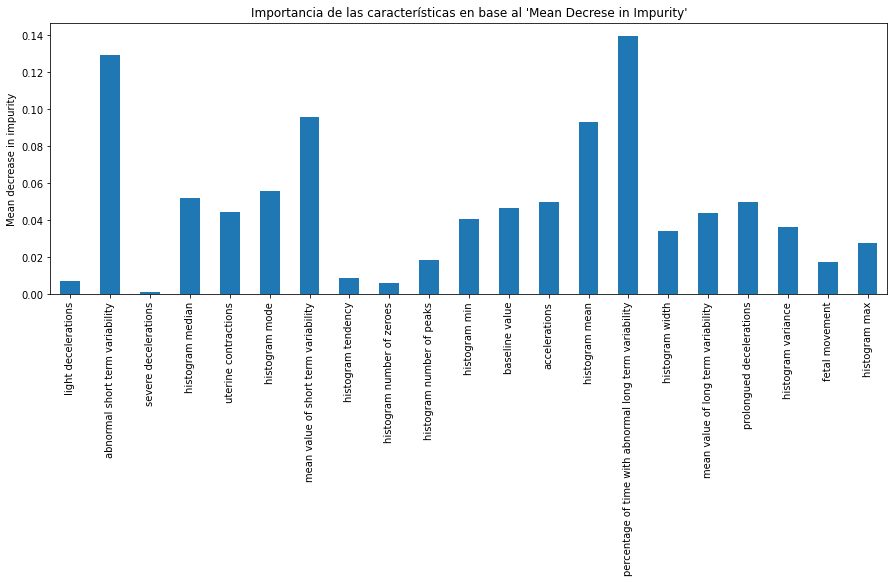

In [ ]:
indices_rf=selection_rf.get_support(indices=True)
names_rf=[]
for i in indices_rf:
    names_rf.append(features[i])

print('\033[1m'+"Total features:", X_tr.shape[1])
print('\033[1m'+"Selected features:",len(indices_rf),"which are:",names_lr2,"\n")
#print(selection_rf.estimator_.feature_importances_) #Importancia de cada característica en este modelo de Random Forest
#print(np.mean(selection_rf.estimator_.feature_importances_)) #Media de las importancias, usada como umbral para seleccionar las más importantes.

import pandas as pd
forest_importances=pd.Series(selection_rf.estimator_.feature_importances_,index=features) #feature_importances_ solo existe para árboles como RF, no para LR.
fig, ax = plt.subplots()
forest_importances.plot.bar()
ax.set_title("Importancia de las características en base al 'Mean Decrese in Impurity'")
ax.set_ylabel("Mean decrease in impurity")

Para el número de estimadores indicado (100, concretamente), hemos llevado a cabo una selección de las características más relevantes por medio de ***Random Forest***, pudiendo asimismo determinar cuáles son estas características y cuáles son más importantes, de forma relativa, visualmente. Recordemos que, para seleccionar las características más importantes, SelectFromModel usa como *threshold* la media de las *feature importances* por defecto, que son las que se están representando en la gráfica superior. 

Asimismo, estas *feature importances* representadas en *Mean decrease in impurity* son una medida de la importancia de cada variable para clasificar correctamente los datos en una categoría, considerando el conjunto de árboles del Random Forest.

---

Al igual que en los apartados anteriores, vamos a comprobar hasta qué punto mejora el *performance* del modelo del experimento 4 (*Random Forest Classifier*) haciendo *Feature Selection* también con *Random Forest*.

A continuación, se muestra una *Pipeline* donde se escalan los datos, se seleccionan las características más importantes (con Random Forest) y se entrena un modelo de Random Forest para nuestros datos, de forma similar a como hicimos en el experimento 4.

In [ ]:
pipeline_rf_selection = Pipeline([("scaler",StandardScaler()),("sel",SelectFromModel(RandomForestClassifier(n_estimators=100))),("RF",RandomForestClassifier())])
param_grid_rfsel = {"RF__n_estimators":[100]}
skfold_rfsel=RepeatedStratifiedKFold(n_splits=5,n_repeats=10)
gridcv_rfsel=GridSearchCV(pipeline_rf_selection,param_grid_rfsel,cv=skfold_rfsel,scoring=make_scorer(balanced_accuracy_score))
result_rfsel=gridcv_rfsel.fit(X_tr, y_tr)
y_ch_p_rfsel=gridcv_rfsel.predict(X_ch)
evaluate_model(gridcv_rfsel, X_tr, y_tr, X_te, y_te)
print("Los mejores parámetros son:",gridcv_rfsel.best_params_)
print("El mejor balanced accuracy score es:",gridcv_rfsel.best_score_)

                 Acc  Bal. Acc
     Train      1.00      1.00
      Test      0.93      0.85
Los mejores parámetros son: {'RF__n_estimators': 100}
El mejor balanced accuracy score es: 0.8426361211149411


In [ ]:
save_predictions(y_ch_p_rfsel)

A continuación, se muestra la misma *Pipeline* (similar a la del experimento 4) sin hacer *Feature Selection*.

In [ ]:
pipeline_rf_no_selection = Pipeline([("scaler",StandardScaler()),("RF",RandomForestClassifier())])
param_grid_no_rfsel = {"RF__n_estimators":[100]}
skfold_no_rfsel=RepeatedStratifiedKFold(n_splits=5,n_repeats=10)
gridcv_no_rfsel=GridSearchCV(pipeline_rf_no_selection,param_grid_no_rfsel,cv=skfold_no_rfsel,scoring=make_scorer(balanced_accuracy_score))
result_no_rfsel=gridcv_no_rfsel.fit(X_tr, y_tr)
y_ch_p_no_rfsel=gridcv_no_rfsel.predict(X_ch)
evaluate_model(gridcv_no_rfsel, X_tr, y_tr, X_te, y_te)
print("El mejor balanced accuracy score es:",gridcv_no_rfsel.best_score_)

                 Acc  Bal. Acc
     Train      1.00      1.00
      Test      0.93      0.85
El mejor balanced accuracy score es: 0.8316899891264491


In [ ]:
save_predictions(y_ch_p_no_rfsel)

Tal y como podemos apreciar, bajo los mismos valores para los distintos parámetros, realizar una selección de características (en este caso con *Random Forest*) mejora en 0.01 unidades el ***balanced accuracy*** del modelo, concretamente *Random Forest* también.

## **7. ¿Cuáles son las características más importantes según el conjunto de modelos?**

Tras realizar los distintos sub-apartados de la sexta sección, obtenemos un listado con las características más relevantes para realizar la clasificación de los datos según cada modelo.

Comparando los distintos listados, identificamos cinco características que, no solo están presentes en todos, sino que también aparecen como significativas según el estadístico F. Estas características son: *abnormal short term variability, baseline value, accelerations, percentage of time with abnormal long term variability, prolongued decelerations*. 

Asimismo, volviendo a la tabla de correlación del apartado 3, podemos comprobar que no aparecen correlacionadas con ninguna otra característica, es decir, son características cuyo valor no depende de los valores del resto, por lo que son independientes, siendo este un requisito importante para una variable predictora.

## **8. Referencias**

1. Apuntes proporcionados por el profesor.
2. https://scikit-learn.org/stable/modules/feature_selection.html
3. https://www.google.com/url?q=https://michael-fuchs-python.netlify.app/2021/02/03/nn-multi-layer-perceptron-classifier-mlpclassifier/%23mlpclassifier-for-multi-class-classification&sa=D&source=editors&ust=1653138127259731&usg=AOvVaw1ea_GJC2hspJx0uey71aYT
4. https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier
5. https://www.google.com/url?q=https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html&sa=D&source=editors&ust=1653138547478593&usg=AOvVaw2QTkGpo9W6DuSXpUXEM1MV
6. https://medium.com/the-artificial-impostor/feature-importance-measures-for-tree-models-part-i-47f187c1a2c3
7. https://community.alteryx.com/t5/Alteryx-Designer-Discussions/Help-Mean-Decrease-in-Gini-for-dummies/td-p/197223
8. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
9. https://towardsdatascience.com/feature-selection-using-regularisation-a3678b71e499
10. https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py
11. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression
12. https://stackoverflow.com/questions/67513075/what-is-c-parameter-in-sklearn-logistic-regression
13. https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html
14. https://towardsdatascience.com/feature-selection-using-logistic-regression-model-efc949569f58
15. https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
16. https://towardsdatascience.com/feature-selection-using-regularisation-a3678b71e499#:~:text=Regularisation%20consists%20in%20adding%20a,multiply%20each%20of%20the%20predictors.
17. https://towardsdatascience.com/feature-selection-using-random-forest-26d7b747597f
18. https://stackoverflow.com/questions/51290659/how-does-selectfrommodel-work-from-from-model-py
19. https://machinelearningmastery.com/calculate-feature-importance-with-python/
20. https://stackoverflow.com/questions/51462979/how-to-get-feature-importance-in-logistic-regression-using-weights
21. https://towardsdatascience.com/a-look-into-feature-importance-in-logistic-regression-models-a4aa970f9b0f
22. https://stackoverflow.com/questions/45330240/scikit-learn-selectfrommodel-actually-obtain-the-feature-importance-scores-of
23. https://medium.com/@GouthamPeri/pipeline-with-tuning-scikit-learn-b2789dca9dc2
24. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
25. https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier
26. https://amueller.github.io/ml-training-intro/slides/03-cross-validation-grid-search.html#19
27. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedStratifiedKFold.html
28. https://medium.com/@sabarirajan.kumarappan/feature-selection-by-lasso-and-ridge-regression-python-code-examples-1e8ab451b94b
29. https://www.yourdatateacher.com/2021/05/05/feature-selection-in-machine-learning-using-lasso-regression/
30. https://interactivechaos.com/es/manual/tutorial-de-matplotlib/graficos-de-dispersion